(1280, 617)


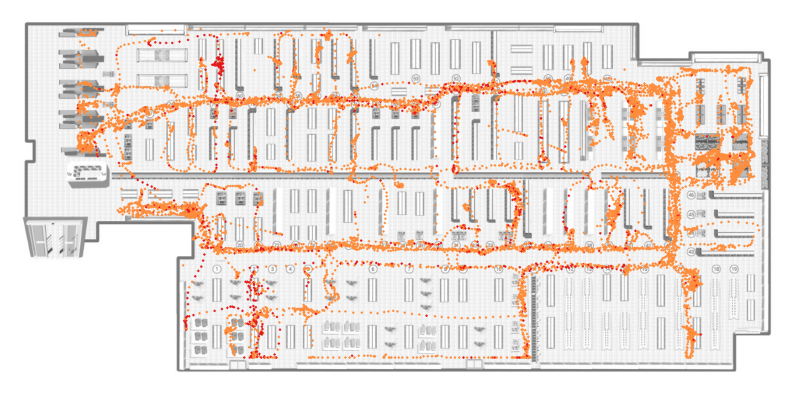

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
from PIL import Image, ImageDraw
import numpy as np

# Add this section to get database connection from a file
from database_connection import create_conn

def draw(df):
    # Get image size with this method
    img = Image.open('./kauppa.jpg')
    width, height = img.size
    print(img.size)

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the image on the axes
    ax.imshow(img, extent=[0, width, 0, height])

    # Draw on image
    d = ImageDraw.Draw(img)

    # Calibration of coordinates
    x_offset = 112  # x offset
    y_offset = 27   # y offset
    x_max = 1076;  # node_x_max = 10406
    y_max = 563;  # node_y_max = 5220
    x_scale = 1140/10406
    y_scale = 566/5220

    def scale_coords(x,y):
        xr = (x*x_scale)+x_offset
        yr = (y*y_scale)+y_offset
        zr = 0
        return xr, yr, zr

    # Normalize the counts for color map
    max_value = df.groupby(['x', 'y']).apply(lambda group: min(group.size, 200000))
    min_value = df.groupby(['x', 'y']).size().min()
    norm_counts = (df.groupby(['x', 'y']).size() - min_value) / (max_value - min_value)

    # Create color map
    cmap = plt.get_cmap('YlOrRd', 5)
    cmap = cmap(np.linspace(0.5, 1, cmap.N))

    vmin = min_value
    vmax = 200000

    for index, row in df.iterrows():
        (x,y,z) = scale_coords(row.x, row.y)
        count = df[(df['x'] == row.x) & (df['y'] == row.y)].count()[0]
        alpha = norm_counts[(row.x, row.y)]
        color = cmap[int(alpha*5)]

        # Draw circles instead of rectangles
        radius = 1.5
        diameter = radius * 2
        x1, y1 = x - radius, y - radius
        x2, y2 = x + radius, y + radius
        d.ellipse([x1, y1, x2, y2], fill=tuple(int(255*c) for c in color[:3]))

    # Plot the heatmap on the axes
    ax.imshow(img, extent=[0, width, 0, height])
    ax.axis('off')

    # Display the figure
    plt.show()

def clear():
    plt.clf()

# Modify this section to use MariaDB database connection
conn = create_conn()
query = "SELECT x, y FROM SensorData LIMIT 20000"

with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()
    columns = [i[0] for i in cursor.description]
    df = pd.DataFrame(result, columns=columns)

conn.close()

# Call the draw function
draw(df)

